In [ ]:
! pip install torch==2.9.0 transformers==4.57.3 matplotlib==3.10.0 pandas==2.2.2 numpy==2.0.2

### Inspecting Next-Token Probability Distributions

Loaded tokenizer: Qwen/Qwen2.5-0.5B
Loaded model: Qwen/Qwen2.5-0.5B
Device: cuda | dtype: torch.float16

Prompt A: The capital of France is
             Paris  0.3193
            ______  0.1139
              ____  0.0638
                __  0.0546
               :\n  0.0505
           located  0.0356
               the  0.0279
                \n  0.0244
                 (  0.0198
               .\n  0.0187

Prompt B: The capital of Germany is
            Berlin  0.1681
                __  0.1174
            ______  0.0958
              ____  0.0559
           located  0.0442
               the  0.0422
               :\n  0.0311
           Hamburg  0.0288
                \n  0.0272
                 (  0.0264


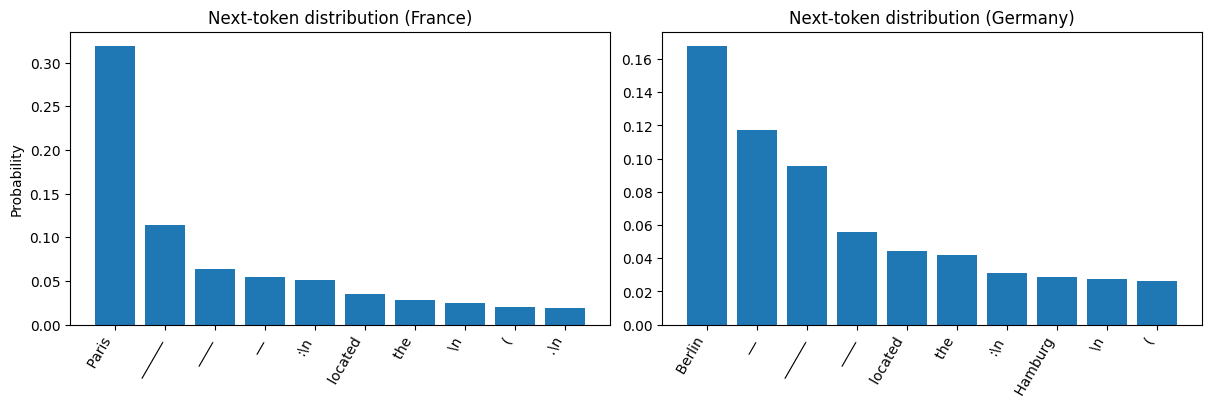

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen2.5-0.5B"

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=dtype,
    trust_remote_code=True
).to(device)

model.eval()

# Qwen configs sometimes have no pad_token set; safest is EOS
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
if model.config.pad_token_id is None:
    model.config.pad_token_id = tokenizer.eos_token_id

print("Loaded tokenizer:", tokenizer.name_or_path)
print("Loaded model:", model.config._name_or_path)
print("Device:", device, "| dtype:", dtype)

def pretty_token(t: str) -> str:
    # Byte-level BPE style space/newline markers
    t = t.replace("Ġ", " ")
    t = t.replace("Ċ", "\\n")
    return t

# Next-token top-k distribution
def get_next_token_topk(prompt, top_k=10):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits[0, -1]     # (vocab,)
    probs = F.softmax(logits, dim=-1)  # (vocab,)

    top_probs, top_ids = torch.topk(probs, top_k)
    tokens = tokenizer.convert_ids_to_tokens(top_ids.tolist())
    pretty = [pretty_token(t) for t in tokens]

    return pretty, top_probs.detach().cpu().tolist()

# Plot helper
def plot_topk(tokens_a, probs_a, tokens_b, probs_b, title_a, title_b):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    axes[0].bar(range(len(tokens_a)), probs_a)
    axes[0].set_xticks(range(len(tokens_a)))
    axes[0].set_xticklabels(tokens_a, rotation=60, ha="right")
    axes[0].set_title(title_a)
    axes[0].set_ylabel("Probability")

    axes[1].bar(range(len(tokens_b)), probs_b)
    axes[1].set_xticks(range(len(tokens_b)))
    axes[1].set_xticklabels(tokens_b, rotation=60, ha="right")
    axes[1].set_title(title_b)

    plt.show()

# Prompts differ by ONE token
prompt_a = "The capital of France is"
prompt_b = "The capital of Germany is"

top_k = 10
tokens_a, probs_a = get_next_token_topk(prompt_a, top_k=top_k)
tokens_b, probs_b = get_next_token_topk(prompt_b, top_k=top_k)

print("\nPrompt A:", prompt_a)
for t, p in zip(tokens_a, probs_a):
    print(f"{t:>18}  {p:.4f}")

print("\nPrompt B:", prompt_b)
for t, p in zip(tokens_b, probs_b):
    print(f"{t:>18}  {p:.4f}")

plot_topk(
    tokens_a, probs_a,
    tokens_b, probs_b,
    title_a="Next-token distribution (France)",
    title_b="Next-token distribution (Germany)"
)

### Pretrained vs Instruction-Tuned (finetuned) model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

BASE_ID = "Qwen/Qwen2.5-0.5B"
INST_ID = "Qwen/Qwen2.5-0.5B-Instruct"

def load(model_id):
    tok = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
    mdl = AutoModelForCausalLM.from_pretrained(
        model_id,
        dtype="auto",
        device_map="auto",
        trust_remote_code=True
    )
    if tok.pad_token_id is None:
        tok.pad_token = tok.eos_token
    return tok, mdl

base_tok, base_m = load(BASE_ID)
inst_tok, inst_m = load(INST_ID)

@torch.inference_mode()
def gen_base(prompt, max_new_tokens=80):
    x = base_tok(prompt, return_tensors="pt").to(base_m.device)
    y = base_m.generate(
        **x,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=base_tok.eos_token_id,
    )
    return base_tok.decode(y[0], skip_special_tokens=True)

@torch.inference_mode()
def gen_instruct(user_prompt, max_new_tokens=80):
    # Proper chat formatting for instruct model
    chat = [{"role": "user", "content": user_prompt}]
    prompt = inst_tok.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    x = inst_tok(prompt, return_tensors="pt").to(inst_m.device)
    y = inst_m.generate(
        **x,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=inst_tok.eos_token_id,
    )
    out = inst_tok.decode(y[0], skip_special_tokens=True)
    # Trim the echoed prompt if present
    return out[len(inst_tok.decode(x["input_ids"][0], skip_special_tokens=True)) :].strip()

tests = [
    "How do I make a pizza?",
    "Write a haiku about summer.",
]

for p in tests:
    print("\n" + "="*90)
    print("PROMPT:", p)
    print("-"*90)
    print("BASE (pretrained):")
    print(gen_base(p))
    print("-"*90)
    print("INSTRUCT (fine-tuned):")
    print(gen_instruct(p))



PROMPT: How do I make a pizza?
------------------------------------------------------------------------------------------
BASE (pretrained):
How do I make a pizza? How do I make pizza dough?
What is the best way to make pizza dough?
Do those questions have the same meaning?
Available options:
a). no;
b). yes;
b).
------------------------------------------------------------------------------------------
INSTRUCT (fine-tuned):
To make a delicious pizza at home, follow these steps:

1. Gather your ingredients:
   - 2-3 pizzas (or equivalent in the size of your oven)
   - Olive oil or other cooking oil
   - 4-6 slices of cheese
   - A small bag of tomato sauce
   - A small bag of marinara sauce or any other type of sauce you prefer
   - 20-30 pieces of bread, such as whole wheat or rye
   - Optional toppings: pepperoni, mushrooms, bell peppers, onions, olives, etc

PROMPT: Write a haiku about summer.
-----------------------------------------------------------------------------------------